<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/CIFAR_100_TrainValid_Gamma_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gamma Correction as Augmentaion

In [3]:
############## Start Gamma Correction ############
import torch
import torchvision.transforms.functional as TF
import numbers

class GammaCorrectionTransform:
    """Apply Gamma Correction to the image"""
    def __init__(self, gamma=0.5):
        self.gamma = self._check_input(gamma, 'gammacorrection')   
        
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with length 2.".format(name))

        # if value is 0 or (1., 1.) for gamma correction do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    def __call__(self, img):
        """
        Args:
            img (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: gamma corrected image.
        """
        gamma_factor = None if self.gamma is None else float(torch.empty(1).uniform_(self.gamma[0], self.gamma[1]))
        if gamma_factor is not None:
            img = TF.adjust_gamma(img, gamma_factor, gain=1)
        return img
############## End Gamma Correction ############

CIFAR-100 contains 500000 samples in training set. We split to 40000/10000 for train and validation.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='CIFAR-10H Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=1024, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=100, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=100, help='number classes')
args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total


CIFAR-100 TrainValid Dataloader

In [5]:
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt

class CIFAR100_TrainValid(torchvision.datasets.CIFAR100):

    def __init__(self, root,  rand_number=0, istrain=True, train=True, transform=None, target_transform=None,
                 download=False):
        super(CIFAR100_TrainValid, self).__init__(root, train, transform, target_transform, download) 
        self.transform = transform
        self.target_transform = target_transform
        if istrain:
            self.data, self.targets = self.data[:40000], self.targets[:40000]
            
        else:
            self.data, self.targets = self.data[40000:], self.targets[40000:]

        hist = np.histogram(self.targets, bins=100, range=(0,100))[0]
        print(hist)
        #plt.hist(self.targets, bins='auto')
        plt.bar(np.arange(len(hist)),hist)
        plt.show()
    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
[397 387 402 398 389 391 404 391 423 398 374 398 398 393 415 393 414 408
 413 416 398 409 412 396 395 386 396 398 382 390 391 413 417 412 409 401
 401 390 408 391 409 396 410 413 396 394 394 388 399 403 388 395 383 389
 415 396 398 396 413 414 416 414 399 402 402 408 413 411 406 410 405 417
 412 398 395 394 395 395 408 394 387 408 395 401 391 397 389 405 393 405
 392 386 414 405 384 392 386 386 398 406]


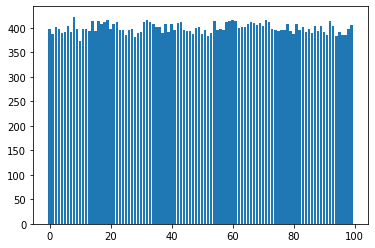

Files already downloaded and verified
[103 113  98 102 111 109  96 109  77 102 126 102 102 107  85 107  86  92
  87  84 102  91  88 104 105 114 104 102 118 110 109  87  83  88  91  99
  99 110  92 109  91 104  90  87 104 106 106 112 101  97 112 105 117 111
  85 104 102 104  87  86  84  86 101  98  98  92  87  89  94  90  95  83
  88 102 105 106 105 105  92 106 113  92 105  99 109 103 111  95 107  95
 108 114  86  95 116 108 114 114 102  94]


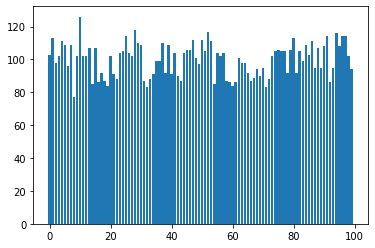

train samples: 40000 valid samples: 10000


In [6]:
seed_everything()
mean_cifar100, std_cifar100 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomApply(transforms=[GammaCorrectionTransform(gamma=0.1)], p=0.5),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar100, std_cifar100), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar100, std_cifar100),])

train_dataset = CIFAR100_TrainValid(root='./data', istrain=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
test_dataset = CIFAR100_TrainValid(root='./data', istrain=False, download=True, transform=transform_train)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
print('train samples:',len(train_dataset), 'valid samples:',len(test_dataset))

In [7]:
model = models.resnet34(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_cifar10h.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch: 0  acc: 0.0102  best epoch: 0  best acc: 0.0102
epoch: 1  acc: 0.1824  best epoch: 1  best acc: 0.1824
epoch: 2  acc: 0.1789  best epoch: 1  best acc: 0.1824
epoch: 3  acc: 0.0626  best epoch: 1  best acc: 0.1824
epoch: 4  acc: 0.0518  best epoch: 1  best acc: 0.1824
epoch: 5  acc: 0.2202  best epoch: 5  best acc: 0.2202
epoch: 6  acc: 0.2106  best epoch: 5  best acc: 0.2202
epoch: 7  acc: 0.2910  best epoch: 7  best acc: 0.2910
epoch: 8  acc: 0.3302  best epoch: 8  best acc: 0.3302
epoch: 9  acc: 0.3481  best epoch: 9  best acc: 0.3481
epoch: 10  acc: 0.3506  best epoch: 10  best acc: 0.3506
epoch: 11  acc: 0.3961  best epoch: 11  best acc: 0.3961
epoch: 12  acc: 0.3864  best epoch: 11  best acc: 0.3961
epoch: 13  acc: 0.3756  best epoch: 11  best acc: 0.3961
epoch: 14  acc: 0.4065  best epoch: 14  best acc: 0.4065
epoch: 15  acc: 0.4181  best epoch: 15  best acc: 0.4181
epoch: 16  acc: 0.3049  best epoch: 15  best acc: 0.4181
epoch: 17  acc: 0.4070  best epoch: 15  best acc: 0